# Research sandbox

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})) \},$ \
$V'(s) = H(s -s_{\text{jam}})\lambda\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{\text{jam}},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +\sigma_R\sqrt{2 b^{-1}} \xi_n,\ b>0,\\
    \dot v_n = \tau_n^{-1}[{( V_n(s_n)+\varepsilon_n)\times w(\Delta t)-v_n}],\ \tau_n>0,\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{(V_n(s_n) +\varepsilon_n(t+\delta))\times w(\Delta t)-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{\text{des}} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_{\text{des}}-\alpha\right]
\end{equation}$

In [1]:
import os
import json
import zipfile
import logging
import warnings

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
from math import exp
from scipy.optimize import minimize
from scipy.stats import linregress
from numpy.linalg import norm
from numpy import array, arange, degrees, diff, mean, sign, unique, where
from numpy.polynomial import Polynomial
from numpy.random import default_rng
from pNeuma_simulator.results import percolate

In [4]:
from pNeuma_simulator import params
from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov
from pNeuma_simulator.animations import ring

In [5]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
        # "pdf.fonttype": 42,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

In [6]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [7]:
# non_empty = []
# empty = []
# items = None
# n_cars = 12
# n_moto = 8
# permutation = (n_cars, n_moto)
# n_cars, n_moto = permutation
# load = True
# if load:
#    items = loader(permutation, path="./output/")
# for item in items:
#    if isinstance(item[0], list):
#        non_empty.append(item)
#    else:
#        empty.append(item)
# len(non_empty)

In [8]:
path = "./output/"
os.makedirs(path, exist_ok=True)
n_cars = 12
n_moto = 6
permutation = (n_cars, n_moto)

In [9]:
# def loader(permutation, verbose=True):
verbose = True
items = []
with zipfile.ZipFile(f"{path}{permutation}.zip", "r") as ziph:
    # ziph is zipfile handle
    for filename in ziph.namelist():
        if filename.endswith(").jsonl"):
            # Opening JSONL file
            with ziph.open(filename, "r") as openfile:
                # Reading from JSONL file
                # https://stackoverflow.com/questions/2081836/
                for i, line in enumerate(tqdm(openfile)):
                    item = json.loads(line)
                    if isinstance(item[0], list):
                        items.append(item)
                if verbose:
                    print(openfile.name)
#   return items

0it [00:00, ?it/s]

(12, 6).jsonl


In [10]:
# Pseudorandom number generator
seed = 1024
rng = default_rng(seed)
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [11]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [12]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(diff(sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [13]:
percolation = percolate(items, n_moto, rng, start=5)

In [14]:
permutation = (12, 6)
x, y, low, high = percolation
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
p_c = 1 - T_c / T_max
print(abs(NU - slope), T_c, r_value**2)

4.3464705590245956e-07 40.877841186523426 0.9959507723313434


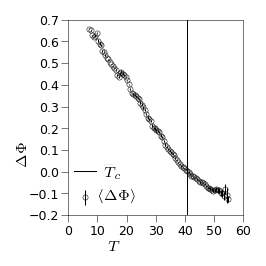

In [15]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
ax.errorbar(
    x,
    y,
    yerr=high - low,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\langle \Delta\Phi \\rangle$",
)
ax.text(
    0.4,
    0.06,
    f"$\langle \Delta\Phi \\rangle$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.text(
    0.3,
    0.18,
    f"$T_c$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
)
ax.set_xlabel("Temperature $T$", usetex=True, labelpad=0)
ax.set_ylabel("Percolation $\Delta\Phi$", usetex=True, labelpad=0)
ax.legend(
    loc=[0, 0.015],
    frameon=False,
    handletextpad=0.5,
    handlelength=1.5,
    fontsize=7,
)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

In [16]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(unique(np.log(x)[y > 0])),
        np.exp(p_fitted(unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\langle \Delta \Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

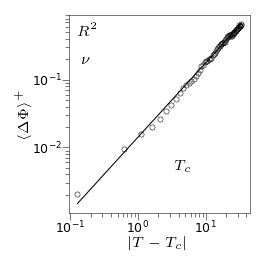

In [17]:
draw_law(renorm, y, r_value**2, save=False)

In [18]:
for n, item in enumerate(items):
    for t, frame in enumerate(array(item[0])):
        for i in range(n_moto):
            if frame[-i]["a_des"] != frame[-i]["a0"]:
                print(n, t, i)
            # break
    # else:
    #    continue  # only executed if the inner loop did NOT break
    # break  # only executed if the inner loop DID break

In [19]:
frame[-i]

{'ID': 26,
 'mode': 'Moto',
 'a_des': -0.08607127050875671,
 'a0': -0.08607127050875671,
 'ttc': 27.048466802728754,
 'f_a': [1.4871703199235047,
  1.5084996802984207,
  1.5308092066888168,
  1.5541596437300955,
  1.578618701938244,
  1.6042621445941097,
  1.6311750946835952,
  1.6594536271685276,
  1.6892067042742815,
  1.7205585643720305,
  1.7536516706064464,
  1.7886853656348813,
  1.8258083006137826,
  1.8652711004730873,
  1.9073504980680962,
  1.952381644995786,
  2.000776627112661,
  2.0530512583140754,
  2.109865218037997,
  2.1720848123607848,
  2.2408865100564195,
  2.317939903150201,
  2.4058112193457113,
  2.508627073523737,
  2.634371819524111,
  2.8030237895993966,
  3.167392856196522,
  5.696698922877525,
  5.958911159223126,
  6.316528061160624,
  12.145478764530683,
  3.5754327771110437,
  3.387001440458256,
  3.2682903889660806,
  3.1825967950995393,
  3.1178308799424497,
  3.0681017942567523,
  3.0300372162409293,
  3.0014339417683806,
  2.980805857036912,
  2.96708

In [20]:
def inner_loop(frame):
    deg_range = []
    vel_car = []
    vel_x = []
    vel_y = []
    for j, _ in enumerate(frame):
        vel = frame[j]["vel"]
        v0 = frame[j]["v0"]
        lam = frame[j]["lam"]
        d = frame[j]["d"]
        v_max = ov(params.d_max, lam, v0, d)
        if frame[j]["mode"] == "Car":
            vel_car.append(vel[0] / v_max)
        else:
            alphas = decay(array(vel), frame[j]["theta"])
            degs = degrees(alphas)
            deg_range.append(degs[0] - degs[-1])
            vel_x.append(vel[0] / v_max)
            vel_y.append(vel[1] / v_max)
        phi_cars = mean(vel_car)
        phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
    return deg_range, phi_cars, phi_moto

In [21]:
start = int(len(item[0]) * 2 / 3 - 1)

In [22]:
l_n = []
for n, item in enumerate(items):
    if isinstance(item[0], list):
        l_T = []
        l_DPhi = []
        frames = []
        for t, frame in enumerate(item[0]):
            if t > start:
                deg_range, phi_cars, phi_moto = inner_loop(frame)
                if round(mean(deg_range)) == int(2 * T_c):
                    frames.append(t)
                    l_T.append(mean(deg_range))
                    l_DPhi.append(phi_moto - phi_cars)
        l_T = np.round(l_T) / 2
        if len(l_T) > 0:
            print(n)
            l_n.append(n)

6
7
9
10
13
14
15
17
18
19
22
25
27
30
31


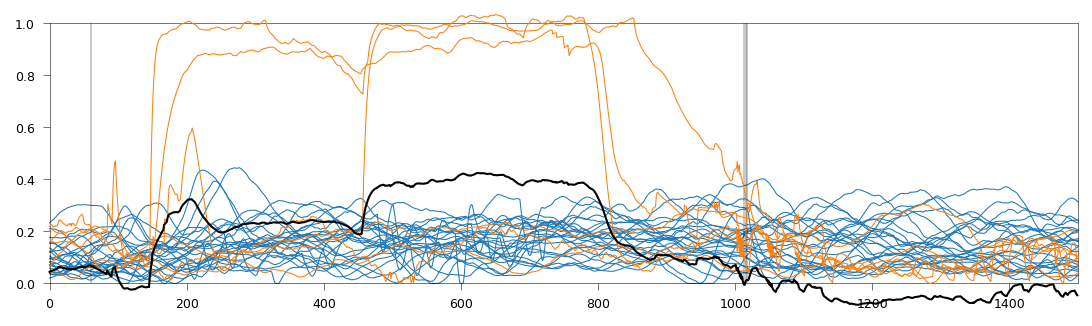

In [23]:
fig, ax = plt.subplots(figsize=(18 * params.cm, 5 * params.cm), dpi=150)
item = items[l_n[0]]
ar = array(item[0])
for i in range(ar.shape[1]):
    speeds = []
    for d in ar[start::1, -(i + 1)]:
        v_max = ov(params.d_max, d["lam"], d["v0"], d["d"])
        speed = d["vel"][0] / v_max
        speeds.append(speed)
    if d["mode"] == "Car":
        zorder = 0
        c = "tab:blue"
    else:
        zorder = 10
        c = "tab:orange"
    plt.plot(speeds, c=c, lw=0.5, clip_on=False, zorder=zorder)
if n_moto > 0:
    l_DPhi = []
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range, phi_cars, phi_moto = inner_loop(frame)
            l_DPhi.append(phi_moto - phi_cars)
            if round(mean(deg_range)) == int(2 * T_c):
                plt.axvline(t - start, c="k", ls="-", lw=0.2)
    plt.plot(l_DPhi, c="k", lw=1, clip_on=False, zorder=100)
ax.set_xlim(0, ar.shape[0] - (start + 1))
ax.set_ylim(0, 1)
fig.tight_layout(pad=0)

In [24]:
frames = []
for t, frame in enumerate(item[0]):
    if t > start:
        for j, _ in enumerate(frame):
            deg_range, phi_cars, phi_moto = inner_loop(frame)
        if np.round(mean(deg_range)) == int(2 * T_c):
            frames.append(t)

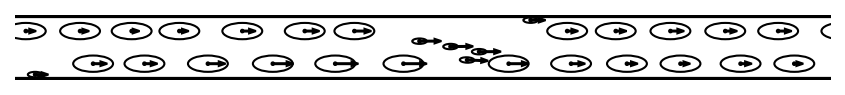

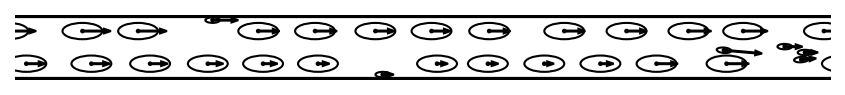

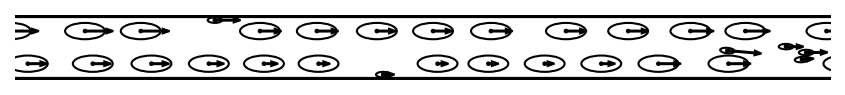

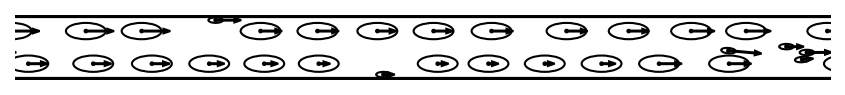

In [25]:
for frame in frames[:]:
    fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
    fig.tight_layout(pad=0)
    ax.set_aspect("equal")
    ring(int(frame), item[0], ax)

In [96]:
from sklearn.metrics import r2_score
from scipy.optimize import root_scalar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [108]:
l_ttc = None
# items = None
dictionary = {}
# Compile the results
compilation = True  # False
min_ttc = 10
max_ttc = 1000
if compilation:
    # for permutation in permutations:
    # if permutation[0] == 14:
    n_cars, n_moto = permutation
    dictionary[str(permutation)] = {
        "xs": [],
        "ps": [],
    }
    # items = loader(permutation)
    l_ttc = []
    for item in items:
        if isinstance(item[0], list):
            for _, agents in enumerate(item[0]):
                for agent in agents:
                    ttc = agent["ttc"]
                    if ttc:
                        l_ttc.append(agent["ttc"])
    a = array(l_ttc)
    a = a[(a > min_ttc) & (a < max_ttc)]
    a_count, a_bins = np.histogram(a, bins=max_ttc)
    a_centers = (a_bins[1:] + a_bins[:-1]) / 2
    a_pdf = a_count / sum(a_count)
    mask = a_pdf > 0
    xs = a_centers[mask]
    ps = a_pdf[mask]
    dictionary[str(permutation)]["xs"] = list(xs)
    dictionary[str(permutation)]["ps"] = list(ps)
    l_ttc = None
    # items = None

In [109]:
def ml_estimator(theta, xs, ps):
    left = 0
    right = 0
    denom = 0
    for xi, pi in zip(xs, ps):
        left += pi * np.log(xi)
        right += (xi ** (-theta)) * np.log(xi)
        denom += xi ** (-theta)
    return left - right / denom

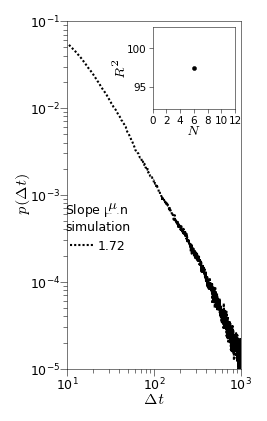

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 8 * params.cm), dpi=150)
ax.set_aspect("equal")
l_n = []
l_r2 = []
l_mu = []
l_w = []
for key, value in dictionary.items():
    if eval(key)[0] == n_cars:
        n = eval(key)[1]
        l_n.append(n)
        xs = dictionary[key]["xs"]
        ps = dictionary[key]["ps"]
        g = lambda theta: ml_estimator(theta, xs, ps)
        sol = root_scalar(g, bracket=[1, 3])
        mu = sol.root
        l_mu.append(mu)
        beta = np.median(np.log(ps) + mu * np.log(xs))
        # measure R2
        y_true = ps
        y_pred = np.exp(beta - mu * np.log(xs))
        r2 = r2_score(np.log(y_true), np.log(y_pred))
        l_r2.append(r2)
        ax.plot(xs, ps, c="k", label=f"{mu:.2f}", ls=(0, (1, 1)), lw=1)
a_n = array(l_n)
a_r2 = array(l_r2)
inds = a_n.argsort()
a_n = a_n[inds]
a_r2 = 100 * a_r2[inds]
inset_ax = inset_axes(
    ax,
    width=0.55,
    height=0.55,
    loc=3,
    bbox_to_anchor=(0.45, 0.725, 0, 0),
    bbox_transform=ax.transAxes,
)
inset_ax.plot(a_n, a_r2, c="k", lw=0.5)
inset_ax.scatter(
    a_n,
    a_r2,
    c="k",
    ec="k",
    marker=".",
    s=15,
    zorder=10,
    lw=0.25,
    clip_on=False,
)
ax.legend(
    frameon=False,
    borderpad=0,
    handletextpad=0.25,
    fontsize=6,
    title_fontsize=6,
    loc=1,
    title="Slope $\mu$ in\nsimulation",
    bbox_to_anchor=(0.4, 0.5),
)
ax.text(
    0.2625,
    0.4525,
    f"$\mu$",
    usetex=True,
    ha="center",
    va="bottom",
    fontsize=6,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    transform=ax.transAxes,
    zorder=10,
)
inset_ax.set_ylabel("$R^2$", labelpad=0, fontsize=6, usetex=True)
inset_ax.set_xlabel("$N$", labelpad=0, fontsize=6, usetex=True)
inset_ax.tick_params(axis="x", pad=1)
inset_ax.tick_params(axis="y", pad=1)
inset_ax.tick_params(axis="both", which="major", labelsize=5, length=2)
inset_ax.set_xlim(0, 12)
inset_ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
# inset_ax.set_yticks([99.1, 99.3, 99.5, 99.7, 99.9])

ax.set_ylabel("$p(\Delta t)$", labelpad=0, usetex=True)
ax.set_xlabel("$\Delta t$", labelpad=0, usetex=True)
ax.set_yscale("log")
ax.set_xscale("log")
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlim(1e1, 1e3)
ax.set_ylim(1e-5, 1e-1)
fig.tight_layout(pad=0)
# plt.savefig(
#    f"/Users/georg/Documents/Figures/ttc_sim.pdf",
#    format="pdf",
#    transparent=True,
# )
plt.show()

In [114]:
l_r2

[0.9739365840402249]